# Monosynaptic pair analysis
-------

Example notebook demonstrating simple functions in SynapticConn for plotting spike trains. 

In [1]:
import os
import pathlib

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

os.chdir('../..')
print(os.getcwd())

from synapticonn.plots import plot_acg, plot_ccg
from synapticonn.postprocessing import compute_crosscorrelogram
from synapticonn.postprocessing import compute_autocorrelogram

import synapticonn as synapticonn

/Users/michael.zabolocki/Desktop/code/SynaptiConn


Load data. 

In [2]:
data_fpath = pathlib.Path('tests', 'BD0187_spikesorting_array.pkl')

# open pickle
all_units = np.load(data_fpath, allow_pickle=True)
all_units = all_units['spike_time_set']
# spike_train_1 = all_units[0]/30_000  # unit 0
# spike_train_2 = all_units[1]/30_000  # unit 1

Set parameters.

In [3]:
srate = 30_000
bin_size_ms = 0.5
max_lag_ms = 25

Initialize the object.

In [4]:
snc = synapticonn.SynaptiConn(all_units, bin_size_ms=1, max_lag_ms=100, srate=30_000, recording_length=600)

Check the loaded spike units.

In [5]:
spk_unit_report = snc.report_spike_units()
pd.DataFrame(spk_unit_report)

,unit_id,n_spikes
0,5,302
1,1,1152
2,0,918
3,16,524
4,17,315
5,18,195
6,15,192
7,4,299
8,3,277


## Auto-correlograms
---

Compute the autocorrelogram for select unit IDs.

Plotting autocorrelogram for spike units: [3 1]


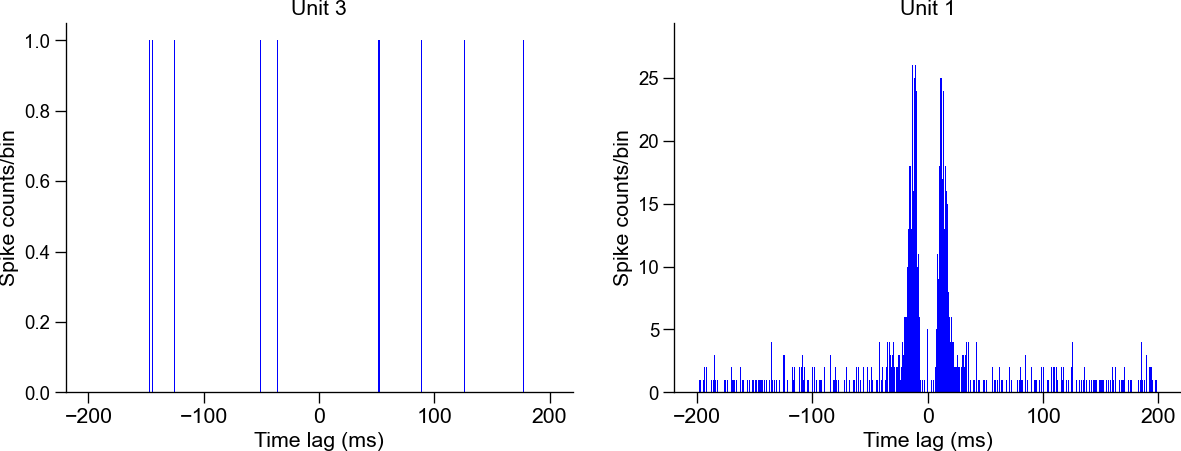

In [31]:
snc.plot_autocorrelogram(spike_units=[3,1,100], color='blue')

Set the bin parameters after initialization, and re-plot.

This can be used to change the binning on the plots, and max time lags.

Plotting autocorrelogram for spike units: [0 1]


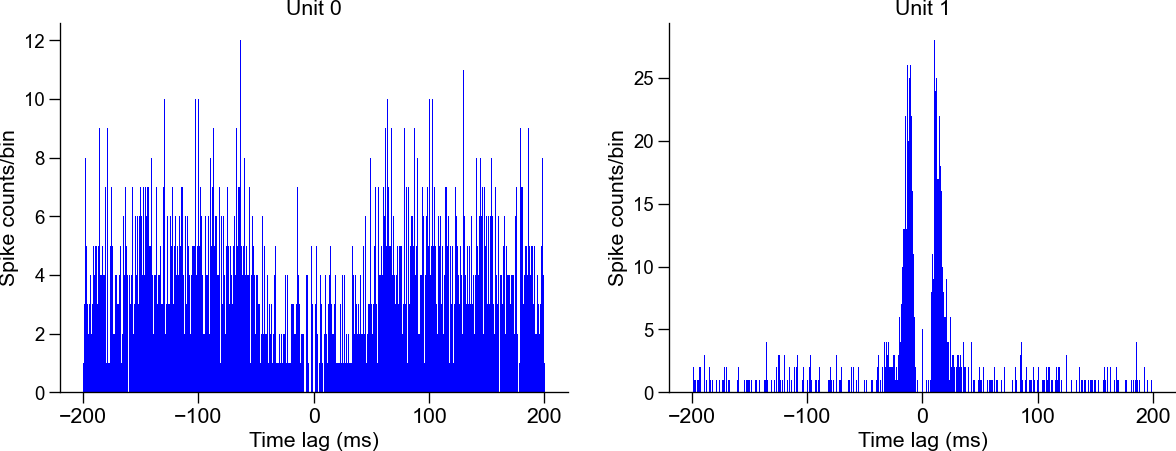

In [7]:
snc.set_bin_settings(bin_size_ms=0.5, max_lag_ms=200)
snc.plot_autocorrelogram(spike_units=[0,1], color='blue')

## Cross-correlograms
----

Plotting cross-correlogram for available spike pairs: [(0, 1), (1, 5), (1, 16)]


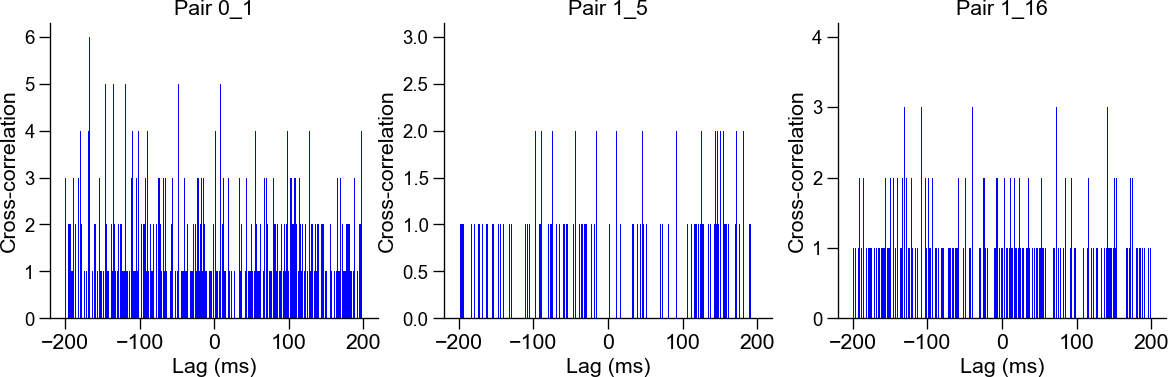

In [9]:
spike_pairs = [(1,16), (1,5), (0,1), (1,16)]
snc.plot_crosscorrelogram(spike_pairs=spike_pairs, figsize=(15, 4))

Alternatively, all possible pairs can be plotted.

In [25]:
# spike_labels = snc.get_spike_unit_labels()

# # get all possible pairs between labels as tuples (including self-pairs)
# spike_pairs = [(i, j) for i in spike_labels for j in spike_labels]
# snc.plot_crosscorrelogram(spike_pairs=spike_pairs, figsize=(20, 30))

## TO DO:
-----

- Test units

- Style is not being fitted globally --> the decorator is useless?

- Document all the steps in place to check this all out ...

- Option to improve the labels here for the units? Check it with different input types

- Build a core object which allows for batch-processing, but also adds in the srates etc. of the recordings

- Option to cross-check with the distances???

- Option to change individual colors for CCGs?

- Merge the CCG and ACG decorators into one?

- For autocorrelograms:
    - ensure that the input is a list type 
    - add a function to check the lags and the bins for this etc.
    - check whether unit ids can be in str format etc.

- Plot_ccg is computing and then plotssing --> should be separate?

- Analysis for CCG and ACG should be separated?